# Duomenų paruošimas neuroniniams tinklams
# 
# Šiame notebook atliksime duomenų paruošimą neuroniniams tinklams, kurie bus naudojami Bitcoin kainos prognozavimui.

In [2]:
# Reikalingų bibliotekų importavimas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import time
import json
import requests
from datetime import datetime, timedelta

# Nustatome atsitiktinių skaičių sėklą, kad rezultatai būtų atkartojami
np.random.seed(42)

# Kintamieji duomenims iš API gauti
BINANCE_API_URL = "https://api.binance.com/api/v3/klines"

In [3]:
# Sukuriame tiesioginį duomenų gavimo metodą iš Binance API, apeinant duomenų bazę
def get_klines_direct(symbol="BTCUSDT", interval="15m", limit=500):
    """
    Tiesiogiai gauna kainos žvakių duomenis iš Binance API
    
    Args:
        symbol: prekybos pora (numatyta BTCUSDT)
        interval: laiko intervalas (numatyta 15m - 15 minučių)
        limit: maksimalus duomenų taškų skaičius (max 1000)
        
    Returns:
        DataFrame su kainos duomenimis
    """
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': min(limit, 1000)  # Binance API riboja iki 1000 duomenų taškų
    }
    
    # Vykdome API užklausą
    try:
        response = requests.get(BINANCE_API_URL, params=params)
        response.raise_for_status()  # Išmetame išimtį, jei HTTP klaida
        
        # Gaunami duomenys yra sąrašas sąrašų
        data = response.json()
        
        # Sukuriame DataFrame su reikiamais stulpeliais
        columns = ['time', 'open', 'high', 'low', 'close', 'volume', 
                   'close_time', 'quote_asset_volume', 'number_of_trades',
                   'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
        
        df = pd.DataFrame(data, columns=columns)
        
        # Konvertuojame tipų formatus
        df['time'] = pd.to_datetime(df['time'], unit='ms')
        numeric_columns = ['open', 'high', 'low', 'close', 'volume']
        df[numeric_columns] = df[numeric_columns].astype(float)
        
        print(f"Sėkmingai gauti {len(df)} įrašai iš Binance API")
        return df
        
    except Exception as e:
        print(f"Klaida gaunant duomenis iš Binance API: {str(e)}")
        return None

# Funkcija gauti duomenis už ilgesnį laikotarpį (daugiau nei 1000 taškų)
def get_historical_klines(symbol="BTCUSDT", interval="15m", start_time=None, end_time=None):
    """
    Gauna istorinius kainos duomenis už bet kokį laikotarpį
    
    Args:
        symbol: prekybos pora (numatyta BTCUSDT)
        interval: laiko intervalas (numatyta 15m - 15 minučių)
        start_time: pradžios laikas (datetime objektas)
        end_time: pabaigos laikas (datetime objektas, numatytas dabar)
        
    Returns:
        DataFrame su kainos duomenimis
    """
    # Nustatome pabaigos laiką į dabartinį, jei nenurodytas
    if end_time is None:
        end_time = datetime.now()
    
    # Nustatome pradžios laiką, jei nenurodytas
    if start_time is None:
        # Kadangi dabar naudosime 15min duomenis, koreguojame laikotarpį
        # Imame 14 dienų duomenis vietoj 6 mėnesių, kad neužklautume API
        start_time = end_time - timedelta(days=14)
    
    # Konvertuojame į UNIX timestamp milisekundėmis
    start_ts = int(start_time.timestamp() * 1000)
    end_ts = int(end_time.timestamp() * 1000)
    
    # Duomenys bus kaupiami čia
    all_klines = []
    
    # Einame per laiko intervalus, maksimalus atkarpa - 1000 duomenų taškų
    current_start = start_ts
    
    while current_start < end_ts:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': end_ts,
            'limit': 1000
        }
        
        try:
            response = requests.get(BINANCE_API_URL, params=params)
            response.raise_for_status()
            klines = response.json()
            
            if not klines:
                # Nėra daugiau duomenų
                break
                
            all_klines.extend(klines)
            
            # Nustatome naują pradžios tašką
            current_start = int(klines[-1][0]) + 1
            
            # Trumpas laukimas, kad neviršytume API limitų
            time.sleep(0.5)
            
        except Exception as e:
            print(f"Klaida gaunant duomenis: {str(e)}")
            # Trumpai laukiame ir bandome dar kartą
            time.sleep(2)
    
    # Sukuriame DataFrame
    if all_klines:
        columns = ['time', 'open', 'high', 'low', 'close', 'volume', 
                   'close_time', 'quote_asset_volume', 'number_of_trades',
                   'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
        
        df = pd.DataFrame(all_klines, columns=columns)
        
        # Konvertuojame tipų formatus
        df['time'] = pd.to_datetime(df['time'], unit='ms')
        numeric_columns = ['open', 'high', 'low', 'close', 'volume']
        df[numeric_columns] = df[numeric_columns].astype(float)
        
        print(f"Sėkmingai gauti {len(df)} įrašai istorinių duomenų")
        return df
    
    return None

# Gauname 14 dienų Bitcoin duomenis su 15min intervalu
end_time = datetime.now()
start_time = end_time - timedelta(days=1825)  
print(f"Gaunami Bitcoin duomenys nuo {start_time.strftime('%Y-%m-%d %H:%M')} iki {end_time.strftime('%Y-%m-%d %H:%M')}...")
df = get_historical_klines(symbol="BTCUSDT", interval="15m", start_time=start_time, end_time=end_time)

# Patikriname rezultatus
if df is not None:
    df.head()
else:
    print("Nepavyko gauti duomenų, tęsti negalima.")

Gaunami Bitcoin duomenys nuo 2020-05-24 03:16 iki 2025-05-23 03:16...
Sėkmingai gauti 175092 įrašai istorinių duomenų


In [4]:
# Duomenų paruošimas
# Išrikiuojame duomenis pagal laiką
df = df.sort_values('time')

# Patikriname duomenis
print(f"Duomenų intervalas: nuo {df['time'].min()} iki {df['time'].max()}")
print(f"Laikotarpis dienomis: {(df['time'].max() - df['time'].min()).days} d {(df['time'].max() - df['time'].min()).seconds // 3600} val")
print(f"Įrašų skaičius: {len(df)}")
print(f"Vidutinis intervalas tarp įrašų: {(df['time'].max() - df['time'].min()) / max(len(df)-1, 1)}")

# Patikriname trūkstamas reikšmes
print("\nTrūkstamos reikšmės:")
print(df.isnull().sum())

# Jei yra trūkstamų reikšmių, užpildome jas
if df.isnull().sum().sum() > 0:
    print("Užpildome trūkstamas reikšmes...")
    df = df.fillna(method='ffill')  # užpildome priekinėmis reikšmėmis
    print("Trūkstamos reikšmės po užpildymo:")
    print(df.isnull().sum())

Duomenų intervalas: nuo 2020-05-24 00:30:00 iki 2025-05-23 00:15:00
Laikotarpis dienomis: 1824 d 23 val
Įrašų skaičius: 175092
Vidutinis intervalas tarp įrašų: 0 days 00:15:00.555139898

Trūkstamos reikšmės:
time                            0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
ignore                          0
dtype: int64


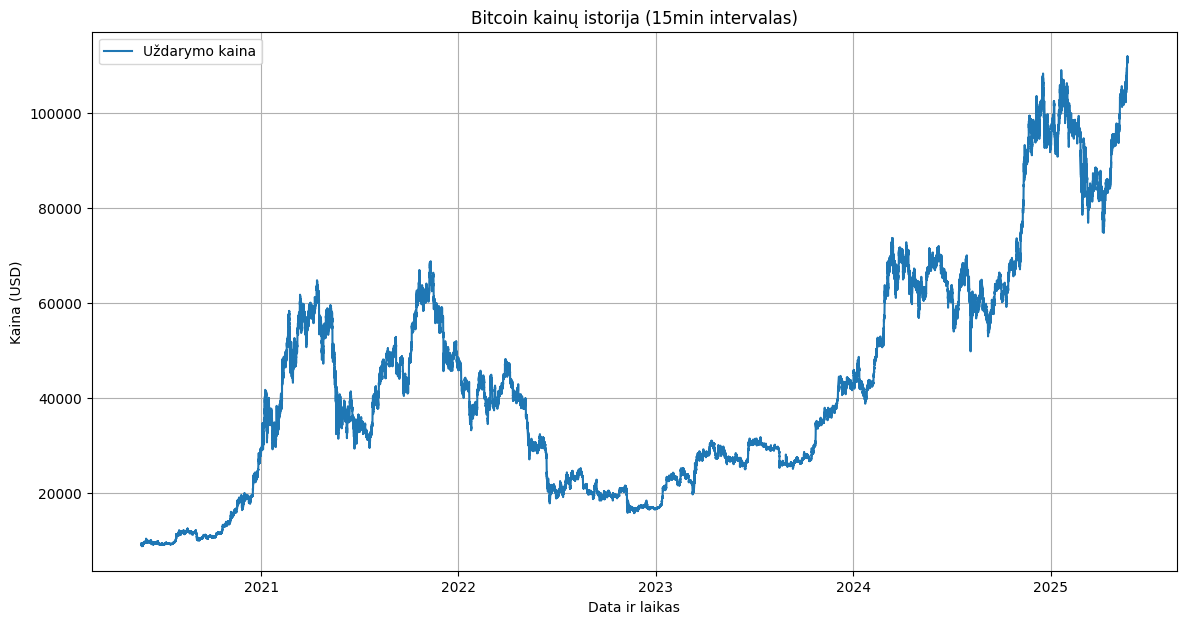

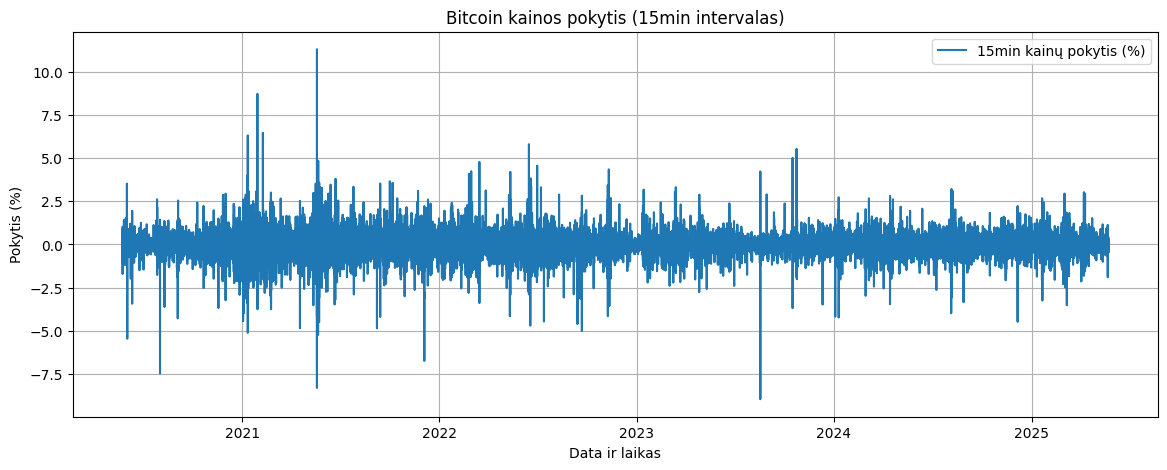

In [5]:
# Duomenų vizualizacija
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['close'], label='Uždarymo kaina')
plt.title('Bitcoin kainų istorija (15min intervalas)')
plt.xlabel('Data ir laikas')
plt.ylabel('Kaina (USD)')
plt.grid(True)
plt.legend()
plt.show()

# Kainos kitimas procentais
df['pct_change'] = df['close'].pct_change() * 100

plt.figure(figsize=(14, 5))
plt.plot(df['time'], df['pct_change'], label='15min kainų pokytis (%)')
plt.title('Bitcoin kainos pokytis (15min intervalas)')
plt.xlabel('Data ir laikas')
plt.ylabel('Pokytis (%)')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
# Duomenų normalizavimas
from sklearn.preprocessing import MinMaxScaler

# Pasirenkame stulpelius, kuriuos normalizuosime
columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']

# Sukuriame scaler objektą
scaler = MinMaxScaler()

# Išsaugome duomenų kopijas prieš normalizavimą
df_original = df.copy()

# Normalizuojame duomenis
df_normalized = df.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

print("Normalizuoti duomenys:")
df_normalized.head()

Normalizuoti duomenys:


,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,pct_change
0,2020-05-24 00:30:00,0.004711,0.004365,0.005117,0.004837,0.010030,1590281099999,3717366.44884640,5848,167.46637900,1537498.14131201,0,NaN
1,2020-05-24 00:45:00,0.004835,0.004582,0.005276,0.004916,0.011350,1590281999999,4215553.77719967,6889,189.94266400,1747587.16810438,0,0.088483
2,2020-05-24 01:00:00,0.004920,0.004551,0.005272,0.004857,0.005000,1590282899999,1856587.14571205,3735,96.89518800,891225.13274693,0,-0.066113
3,2020-05-24 01:15:00,0.004861,0.004584,0.005302,0.005011,0.005061,1590283799999,1879683.45940717,3829,97.19618400,894216.24637652,0,0.172356
4,2020-05-24 01:30:00,0.005015,0.004557,0.005158,0.004870,0.007689,1590284699999,2852393.75504192,5551,142.84578400,1312488.56104957,0,-0.157612


In [7]:
# Sliding window metodo implementacija

def create_sequences(data, target_column, sequence_length):
    """Sukuria sekas naudojant sliding window metodą
    
    Args:
        data: DataFrame su duomenimis
        target_column: stulpelis, kurį bandysime prognozuoti
        sequence_length: kiek praeities įrašų naudosime vienai prognozei
        
    Returns:
        X: įvesties sekos (3D numpy masyvas)
        y: taikinio reikšmės (1D numpy masyvas)
    """
    X = []
    y = []
    
    # Atrenkame tik reikalingus stulpelius
    feature_columns = ['open', 'high', 'low', 'close', 'volume']
    data_array = data[feature_columns].values
    
    # Target stulpelio indeksas
    target_idx = feature_columns.index(target_column)
    
    # Formuojame sekas
    for i in range(len(data) - sequence_length):
        X.append(data_array[i:i + sequence_length])
        y.append(data_array[i + sequence_length, target_idx])
    
    return np.array(X), np.array(y)

# Nustatome sekos ilgį ir tikslo stulpelį
sequence_length = 10  # naudosime 10 žvakių prognozei
target_column = 'close'  # prognozuosime uždarymo kainą

# Sukuriame sekas
X, y = create_sequences(df_normalized, target_column, sequence_length)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Patikriname pirmą seką
print("\nPirmos sekos duomenys (pirmi 3 įrašai):")
print(X[0][:3])
print("\nPirmos sekos tikslas:")
print(y[0])

X shape: (175082, 10, 5)
y shape: (175082,)

Pirmos sekos duomenys (pirmi 3 įrašai):
[[0.00471068 0.00436522 0.00511728 0.00483724 0.01002998]
 [0.00483538 0.00458151 0.00527557 0.00491601 0.0113496 ]
 [0.00492006 0.00455071 0.00527188 0.0048571  0.00499963]]

Pirmos sekos tikslas:
0.004913974204372576


In [8]:
# Duomenų padalijimas į mokymo ir testavimo rinkinius
from sklearn.model_selection import train_test_split

# Padalijame duomenis 80% mokymui, 20% testavimui
# SVARBU: nepersukti duomenų, nes dirbame su laiko eilutėmis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Patikriname, ar testavimo duomenys yra naujesni už mokymo duomenis
last_train_idx = len(X) - len(X_test) - 1
first_test_idx = last_train_idx + 1

print(f"\nPaskutinio mokymo įrašo data: {df_original['time'].iloc[last_train_idx + sequence_length]}")
print(f"Pirmo testavimo įrašo data: {df_original['time'].iloc[first_test_idx + sequence_length]}")

X_train shape: (140065, 10, 5)
X_test shape: (35017, 10, 5)
y_train shape: (140065,)
y_test shape: (35017,)

Paskutinio mokymo įrašo data: 2024-05-23 06:00:00
Pirmo testavimo įrašo data: 2024-05-23 06:15:00


In [9]:

# Duomenų generatoriaus implementacija batch mokymui

def batch_generator(X, y, batch_size=32, shuffle=True):
    """Generuoja duomenų partijas (batches) mokymui
    
    Args:
        X: įvesties duomenys
        y: taikinio reikšmės
        batch_size: partijos dydis
        shuffle: ar maišyti duomenis
        
    Yields:
        X_batch, y_batch: viena duomenų partija
    """
    num_samples = len(X)
    indices = np.arange(num_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, num_samples, batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        yield X[batch_indices], y[batch_indices]

# Testavimas: gaukime vieną batch ir patikriname jo formą
batch_gen = batch_generator(X_train, y_train, batch_size=32)
X_batch, y_batch = next(batch_gen)
print(f"X_batch shape: {X_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

X_batch shape: (32, 10, 5)
y_batch shape: (32,)


In [10]:
# Išsaugome paruoštus duomenis ir scaler
import pickle
import json

data_dir = '../../data/nn_data'
os.makedirs(data_dir, exist_ok=True)

# Sukuriame unikalų pavadinimą pagal datą
current_time = datetime.now().strftime("%Y%m%d_%H%M")
data_filename = f"{current_time}_direct_api"

# Išsaugome duomenis
with open(f'{data_dir}/X_train_{data_filename}.pkl', 'wb') as f:
    pickle.dump(X_train, f)
    
with open(f'{data_dir}/X_test_{data_filename}.pkl', 'wb') as f:
    pickle.dump(X_test, f)
    
with open(f'{data_dir}/y_train_{data_filename}.pkl', 'wb') as f:
    pickle.dump(y_train, f)
    
with open(f'{data_dir}/y_test_{data_filename}.pkl', 'wb') as f:
    pickle.dump(y_test, f)
    
with open(f'{data_dir}/scaler_{data_filename}.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Išsaugome meta informaciją
feature_columns = ['open', 'high', 'low', 'close', 'volume']
meta_info = {
    'sequence_length': sequence_length,
    'target_column': target_column,
    'feature_columns': feature_columns,
    'data_source': 'direct_binance_api',
    'interval': '15m',
    'data_start': df_original['time'].min().strftime("%Y-%m-%d %H:%M"),
    'data_end': df_original['time'].max().strftime("%Y-%m-%d %H:%M"),
    'total_samples': len(df_original),
    'created_at': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'file_prefix': data_filename
}

with open(f'{data_dir}/meta_info_{data_filename}.json', 'w') as f:
    json.dump(meta_info, f, indent=4)

# Taip pat išsaugome standartinius failus, kad kiti modeliai galėtų lengvai naudoti
with open(f'{data_dir}/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
    
with open(f'{data_dir}/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
    
with open(f'{data_dir}/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
    
with open(f'{data_dir}/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)
    
with open(f'{data_dir}/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open(f'{data_dir}/meta_info.json', 'w') as f:
    json.dump(meta_info, f, indent=4)

print(f"Duomenys sėkmingai paruošti ir išsaugoti {data_dir} kataloge.")
print(f"Duomenų failų prefiksas: {data_filename}")
print(f"Naudota duomenų eilučių: {len(df_original)} (nuo {meta_info['data_start']} iki {meta_info['data_end']})")
print("\nDuomenų ruošimo procesas sėkmingai baigtas! Dabar šiuos duomenis galima naudoti neuroninių tinklų mokymui.")

Duomenys sėkmingai paruošti ir išsaugoti ../../data/nn_data kataloge.
Duomenų failų prefiksas: 20250523_0318_direct_api
Naudota duomenų eilučių: 175092 (nuo 2020-05-24 00:30 iki 2025-05-23 00:15)

Duomenų ruošimo procesas sėkmingai baigtas! Dabar šiuos duomenis galima naudoti neuroninių tinklų mokymui.
